In [8]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import numba
from numba import njit, jit
from statistics import mean
from sklearn.datasets.samples_generator import make_blobs
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

class Kmeans(BaseEstimator, ClusterMixin, TransformerMixin):               
    """Performs native k-means on a set of input data """
    def __init__(self, inits=10, k=8, maxit=300, method="++", tol = 1e-3):
        """Simple k-means clustering implementation in pure Python.
        
        Args:
            k (int): number of clusters to fit.
            inits (int): number of independent initializations to perform.
            max_iterations (int): maximum number of iterations to perform.
            method (str): method of choosing starting centers "++" or "rng"
            tol (float): tolerance for early stopping.
        """
        
        self.labels_ = None
        self.cluster_centers_ = None
        self._inits = inits
        self._k = k
        self._maxit = maxit
        self._method = method
        self._tol = tol
       
    """fits given data and calculates cluster centers and labels points accordingly"""

    def fit(self,data):
        self._data = data
        best_clust = float('inf')
        
        for i in (range(self._inits)):
            """random points from the dataset are selected as starting centers """
            if self._method == "rng": # random centers are choosen
                
                dot = np.random.choice(range(len(self._data)), self._k, replace=False)
                self.cluster_centers_ = self._data[dot]
            elif self._method == "++": # kmeans++ is initiated
                
                dot = np.random.choice(len(self._data), replace=False) # random startpunkt
                clusters = np.array([self._data[dot]])
                
                for i in range (self._k-1):
                    D = np.array([])
            
                    for j in range (len(self._data)):
                        D = np.append(D,np.min(np.sum((self._data[j]-clusters)**2, axis = 1)))
                
                     
            
                    p = D/np.sum(D)
                    cummulative_p = np.cumsum(p)
            
                    r = random.random()
                    ind = np.where(cummulative_p >= r)[0][0]
            
                    clusters = np.append(clusters,[self._data[ind]], axis = 0)
                self.cluster_centers_ = clusters
            else:
                raise AttributeError("No valid method")

            old_centroids = None

            for i in range(self._maxit):
                old_centroids = self.cluster_centers_.copy()
                clusters = np.expand_dims(self.cluster_centers_, axis=1)
                data = np.expand_dims(self._data, axis=0)
                eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
                self.labels_ = np.argmin(eucl, axis = 0)
                for i in range(self._k): # range of clusters
                    position = np.where(self.labels_ == i) # position im array bestimmen und dann die entspechenden punkte aus data auslesen
                    
                    if np.any(self.labels_ == i) == False:
                        self.cluster_centers_[i] = self._data[np.random.choice(self._data.shape[0], 1, replace=False)]
                        
                    else:
                        self.cluster_centers_[i] = self._data[position].mean(axis=0)
                    #out = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
                overall_quality = np.sum(np.min(eucl.T**2, axis=1))
                if overall_quality < best_clust:
                    best_clust = overall_quality
                    best_dist = self.labels_
                    best_centers = self.cluster_centers_
                if np.linalg.norm(self.cluster_centers_ - old_centroids) < self._tol:
                    break
            self.cluster_centers_ = best_centers
            self.labels_ = best_dist
            self.inertia_ = best_clust
                
        return self
   
    """predicts for a given dataset the labels"""
    def predict(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
        self.labels_ = np.argmin(eucl, axis = 0)
        return self.labels_ #returns the cluster with minimum distance
    
    """creates a matrix with center-point distance for each point"""
    def transform(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2)
        return eucl.T

class MiniBatchKMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    """Performs mini-batch k-means on a set of input data."""
    def __init__(self, k=8, inits=10, max_iterations=300, tol=1e-3, batch_size=100, method = "++"):
        """Simple mini-batch k-means clustering implementation in pure Python.
        
        Args:
            k (int): number of clusters to fit.
            inits (int): number of independent initializations to perform.
            max_iterations (int): maximum number of iterations to perform.
            tol (float): tolerance for early stopping.
            batch_size (int): number of datapoints for the minibatch.
            method (str): method of choosing starting centers "++" or "rng"
        """
        self.labels_ = None
        self.cluster_centers_ = None
        self._k = k
        self._inits = inits
        self._max_iterations = max_iterations
        self._tol = tol
        self._batch_size = batch_size
        self._method = method
        
    def create_batch(self, data): 

        data_batch = np.random.choice(range(len(data)), self._batch_size, replace=False)
        return data[data_batch]
        
        
        """chooses x (x = batch_size) random points from the data to create the data batch
        """
        
    def initialize(self, data):
        if self._method == "rng":
            indices = np.random.choice(range(len(data)), self._k, replace=False)
            return data[indices], np.zeros(self._k)
        
        elif self._method == "++":
            batch = np.random.choice(len(data), replace=False) # random startpunkt
            clusters = np.array([data[batch]])
                
            for i in range (self._k-1):
                D = np.array([])
            
                for j in range (len(data)):
                    D = np.append(D,np.min(np.sum((data[j]-clusters)**2, axis = 1)))
            
                p = D/np.sum(D)
                cummulative_p = np.cumsum(p)
            
                r = random.random()
                ind = np.where(cummulative_p >= r)[0][0]
            
                clusters = np.append(clusters,[data[ind]], axis = 0)
            return clusters, np.zeros(self._k)
        
    
    def expectation(self, data, centroids): 
        centroids = np.expand_dims(centroids, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        return np.argmin(metric, axis=0)
        
        """measures the euclidean distance between each data_batch points and center points using numpys linalg.norm function
        """
    
    @staticmethod
    @numba.jit(nopython=True)
    def _maximization_aux(data, assignments, centroids, centroid_count): #verschiebt die centroids richtung clustermittelpunkt mit lr
        update = centroids.copy()
        for idx, assignment in enumerate(assignments):
            data_point = data[idx]
            centroid_count[assignment] += 1
            lr = 1 / centroid_count[assignment] #learning rate
            update[assignment] = update[assignment] * (1 - lr) + data_point * lr
        return update
    
        """Moves the centroids to the new centroid point of the assigned data_batch points. But not completely, but according to the learning rate
        """
    
    def maximization(self, data, assignments, centroids, centroid_count): 
        return MiniBatchKMeans._maximization_aux(data, assignments, centroids, centroid_count)
    
        """This part applies maximization_aux on the data using maximization_aux
        """
    
    def final_assignments(self, data, centroids): 
        assignments = []
        for idx in range(len(data) // self._batch_size + 1):
            start = idx * self._batch_size
            stop = min(idx * self._batch_size + self._batch_size, len(data))
            sub_result = self.expectation(data[start:stop], centroids)
            assignments.append(sub_result)
        return np.concatenate(assignments, axis=0)
    
        """Assignes the rest of the data points to the centroids, which were determined before (not only batch_points)
        """
    
    def fit(self, data): #alles zusammen
        centroids, counts = self.initialize(data)
        
        old_centroids = None
        for idx in range(self._max_iterations):
            old_centroids = centroids.copy()
            
            batch = self.create_batch(data)
            assignments = self.expectation(batch, centroids)
            centroids = self.maximization(batch, assignments, centroids, counts)
            
            if np.linalg.norm(centroids - old_centroids) < self._tol:
                break

        self.labels_ = self.final_assignments(data, centroids)
        self.cluster_centers_ = centroids
                
        return self
    
    def predict(self, data):
        
        centroids = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        self.labels_ = np.argmin(metric, axis=0)
        
        return self.labels_

    
    def transform(self, data):
        
        centroids = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        
        return metric.T



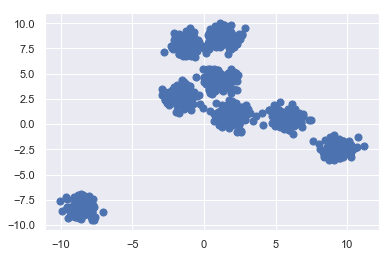

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import sklearn.cluster as sk
from sklearn.datasets.samples_generator import make_blobs #random data generator
 
my_tuple = X, y_true = make_blobs(n_samples=1000, centers=8,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [9]:
me = MiniBatchKMeans(k=8)
me.fit(X)

MiniBatchKMeans(batch_size=None, inits=None, k=None, max_iterations=None,
        method=None, tol=None)

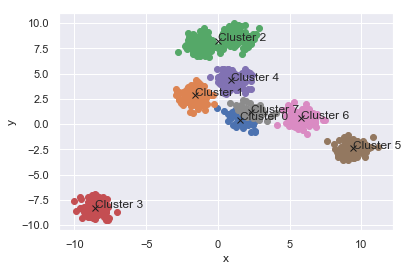

In [7]:
def plot(data, dist, clusters,k, x="x", y="y"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(k):
        graph = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
        center = pd.DataFrame(clusters[i]).T
        #print("Cluster"+ str(i) +  " -- Assigned Points \n" + str(graph))
        ax.plot(graph[0], graph[1], "o")
        ax.plot(center[0],center[1], "kx")
        ax.annotate("Cluster " + str(i), xy = (center[0],center[1])
            )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    plt.show

plot(X,me.labels_, me.cluster_centers_, 8)